# 로지스틱 회귀

In [1]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [2]:
fish.shape

(159, 6)

In [3]:
print(pd.unique(fish['Species'])) # Species열의 고유한 값들 출력 -> 어떤 종류의 생선이 있는지 알 수 있음

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


In [4]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

In [5]:
print(fish_input[:5]) # 5개의 특성이 잘 저장되었는지 처음 5개 행 출력해보기

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


In [6]:
fish_target = fish['Species'].to_numpy() # 1개 열 선택할 때는 []를 1개만 씀ㅇㅇ

In [7]:
print(fish_target[:5])

['Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [8]:
# 데이터를 훈련 세트와 테스트 세트로 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

In [9]:
# 데이터를 표준화 전처리하기
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [10]:
# KNN으로 test_set에 들어있는 생선들의 확률을 구해보자
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


In [11]:
# 이 task는 각 클래스별 확률을 구하기 위한 게 목적이니까
# 훈련 세트와 테스트 세트 점수에 대해서는 잠시 잊자 ^^
# 타깃 데이터에 2개 이상의 클래스가 포함된 이런 문제를 '다중 분류'라고 부른다!
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [12]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [13]:
# 예측한 클래스별 확률 출력해보자
import numpy as np

proba = kn.predict_proba(test_scaled[:5]) # 이 메서드로 클래스별 확률값 반환 가능
print(np.round(proba, decimals=4)) # 소수점 4째 자리까지 표기한다 <- 5번째 자리에서 반올림한다.

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [14]:
# 이 모델이 계산한 확률이, 가장 가까운 비율과 맞는지 확인해보쟈!
# 4번째 샘플의 최근접 이웃의 클래스를 확인해봅시다
distance, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes]) # 4번째 놈의 주변놈들은 train에 있는놈들이잔아!

[['Roach' 'Perch' 'Perch']]


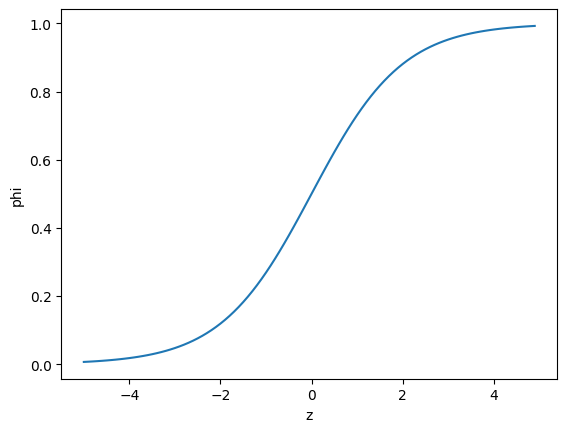

In [15]:
# 근데 3개의 최근접 이웃을 사용하므로 가능한 확률이 0, 0.3333, 0.666 이렇게 3개밖에 없음
# 확률이라고 말하기가 좀;; 글치? .. 좀 더 좋은 방법을 찾아봅시다

# Logistic Regression!!!! ㄱㅂㅈㄱ
# 이놈은 이름은 회귀이지만 분류모델임
# 그 전에 시그모이드 함수 확인해보기
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1)
phi = 1 / (1+np.exp(-z))
plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

In [16]:
# 로지스틱 회귀 모델을 훈련해보자!!
# 훈련하기 전에 간단한 이진 분류 해보기

In [17]:
# 넘파이 배열은 불리언 인덱싱이 가능
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


In [18]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
# 왼쪽꺼로 t,t,f,f,f,t,f,t...이렇게 나온걸 f,t,f,t,f,t,f,f,.. 이런 애랑 합치면 t|f=t -> 그래서 bream,smelt일때만 t고 나머지는 f됨
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]
# 그럼 여기들에는 bream과 smelt데이터만 있겠네

In [19]:
target_bream_smelt

array(['Bream', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Smelt', 'Bream', 'Smelt',
       'Smelt', 'Bream', 'Smelt', 'Bream', 'Bream'], dtype=object)

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [21]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [22]:
print(lr.classes_)

['Bream' 'Smelt']


In [23]:
# 로지스틱 회귀로 성공적인 이진 분류를 수행함!!
# 이제 선형 회귀에서처럼 로지스틱 회귀가 학습한 계수를 확인해보자~~

print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


In [24]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions) # z값들 출력해보기

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


In [25]:
# 이 값들을 시그모이드 함수에 통과시키면 -> 확률 얻을 수 있음!!
from scipy.special import expit

print(expit(decisions))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


In [26]:
# 이제 7개 생선중 하나로 분류하는 다중 분류를 해보자!
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [27]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [28]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [29]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [30]:
# 다중 분류는 소프트맥스 함수를 사용해서 7개의 z값을 확률로 변환함
# 이 함수는 여러 개의 선형 방정식의 출력값을 0~1사이로 압축하고 전체 합이 1이 되도록 만듦.
# 소프트맥스 함수를 직접 적용해보자!

# 테스트 세트의 처음 5개 샘플에 대한 z1~z7값 구하기
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


In [31]:
from scipy.special import softmax
proba = softmax(decision, axis=1) # axis=1 -> 각 행에 대해 소프트맥스 계산
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


# 확률적 경사 하강법

In [32]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv_data')

In [33]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

In [34]:
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

In [35]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [53]:
# 확률적 경사하강법 적용하기
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=100, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8403361344537815
0.8


In [54]:
sc.partial_fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.907563025210084
0.925


In [58]:
# 훈련 세트, 테스트 세트의 에폭-정확도 그래프 그려보기
sc = SGDClassifier(loss='log_loss', random_state=42)
# 에폭마다 훈련셋과 테스트셋에 대한 점수 기록을 위한 리스트들
train_score = []
test_score = []
classes = np.unique(train_target) # train_target에 있는 7개의 생선 목록
classes

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [59]:
# 300에폭 반복 훈련
for _ in range(300):
  sc.partial_fit(train_scaled, train_target, classes=classes)
  train_score.append(sc.score(train_scaled, train_target))
  test_score.append(sc.score(test_scaled, test_target))

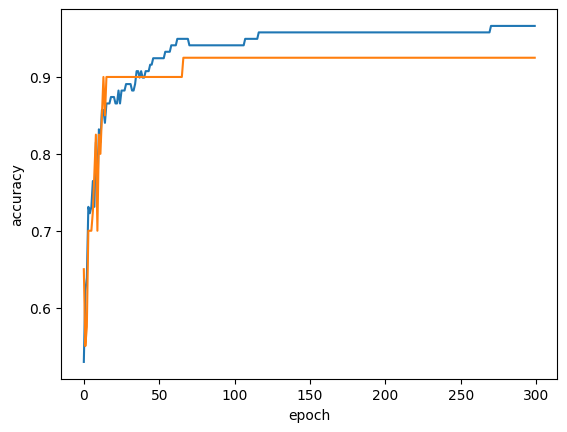

In [60]:
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- 100번째쯤 에폭 이후 훈련셋과 테스트셋의 점수차가 점점 벌어짐

In [66]:
sc = SGDClassifier(loss='log_loss', max_iter=100, tol=None, random_state=42) # SGDClassifier가 일정 에포크 만큼 성능이 향상되지 않으면 멈추는데 그걸 방지하기 위한 매개변수가 tol임
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925
